# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Deepfinder


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

1. 师徒相授：有监督学习（Supervised Learning）
2. 见微知著：无监督学习（Un-supervised Learning）
3. 无师自通：自监督学习（Self-supervised Learning）
4. 以点带面：半监督学习（Semi-supervised learning）
5. 明辨是非：对比学习（Contrastive Learning）
6. 举一反三：迁移学习（Transfer Learning）
7. 针锋相对：对抗学习（Adversarial Learning）
8. 众志成城：集成学习(Ensemble Learning) 
9. 殊途同归：联邦学习（Federated Learning）
10. 百折不挠：强化学习（Reinforcement Learning）
11. **求知若渴：主动学习（Active Learning）**
12. 万法归宗：元学习（Meta-Learning）

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> 主动学习的动机
---
主动学习（Active Learning）是一种机器学习范式，旨在通过选择最有价值的样本进行标注，**从而在减少标注成本的同时提高模型性能**。

主动学习的核心思想是：**让模型主动选择那些对自身学习最有帮助的样本进行标注，而不是随机选择样本**。通过这种方式，主动学习可以在较少的标注数据下，训练出性能更好的模型。

支持向量机（SVM）的核心原理是通过少量的支持向量来定义决策边界，而不是依赖于整个数据集。这些支持向量是距离决策边界最近的点，它们决定了分类器的最终形态。在主动学习的背景下，这一特性与主动学习的理念不谋而合——两者都强调从大量数据中识别出最关键的信息。

---

 **主动学习的基本组成部分（Basic components of Active Learning）**





* 未标记数据池（Unlabeled Data Pool）：大量未标记的数据，是主动学习的基础。

* 已标记数据集（Labeled Data Set）：初始可能为空，随着学习的进行逐渐增加。

* 学习器（Learner）：从已标记数据中学习模型。

* 预言机（Oracle）：生成真实标签的过程，通常由人类标注员完成。

**主动学习的常用方法**

* **不确定性采样（Uncertainty Sampling）**： 选择模型最不确定的样本进行标注。

* 常用标准：

   ○ 最小置信度分数（Least Confidence）：选择模型最不确定的样本。

   ○ 最小间隔分数（Minimum Margin）：选择模型在两个最可能类别之间犹豫不决的样本。

   ○ 熵分数（Entropy）：选择模型预测熵最高的样本。


* **委员会查询（Query-by-Committee, QBC）**： 使用多个模型（委员会）的预测分歧来选择样本。

* 常用标准：

   ○ 投票熵（Vote Entropy）：基于委员会成员的投票结果计算熵。

   ○ 共识熵（Consensus Entropy）：基于委员会成员的概率估计计算熵。

   ○ KL 散度（Kullback-Leibler Divergence）：衡量委员会成员与整体共识的分歧。


* **预期模型变化（Expected Model Change, EMC）**： 

   ○ 选择那些能够最大程度改变模型的样本。

   ○ 通过计算梯度的预期长度来近似模型变化。


* **预期误差减少（Expected Error Reduction, EER）**：

   ○ 选择那些能够最大程度减少模型在未来数据上误差的样本。

   ○ 需要重新训练模型，计算成本较高。


* **密度加权（Density Weighting）**：

   ○ 在选择样本时，不仅考虑模型的不确定性，还考虑样本在数据分布中的密度。

   ○ 避免选择稀疏区域或异常值的样本。

In [1]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, ortho_group
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from typing import Callable, Sequence, Tuple, Optional
from random import choice

# 设置 Seaborn 样式
sns.set_style("white")
colors = sns.color_palette(n_colors=10)

**从两个高斯分布中抽取二维数据样本**，调整种子以获得不同形状的高斯分布。

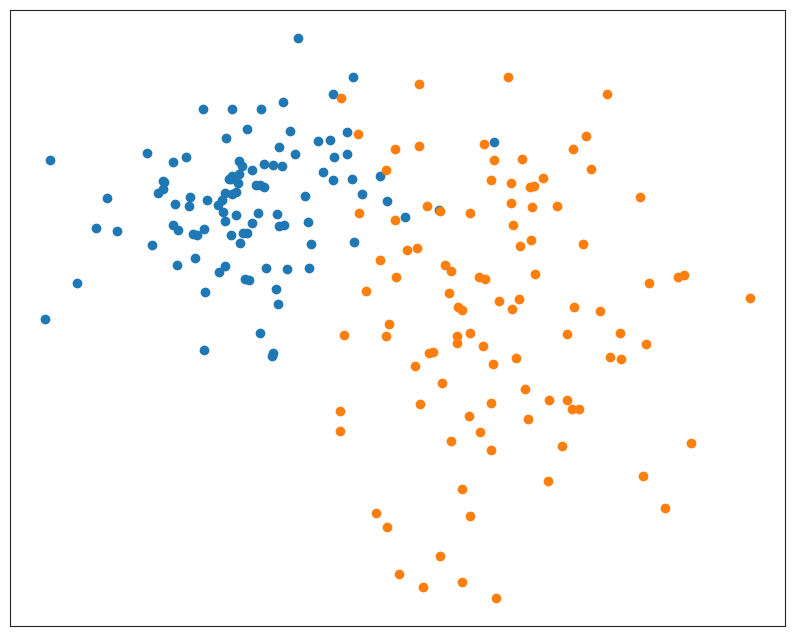

In [2]:
# 定义辅助函数
def sample_covar(dim: int = 2, scale_min: float = 0.3, scale_max: float = 5) -> np.ndarray:
    """Construct random covariance matrix by sampling a rotation and scale matrix."""
    R = ortho_group.rvs(dim) * (np.random.rand(dim, dim) * (scale_max - scale_min) + scale_min)
    return R.dot(R.T)

# 生成示例数据
N_1, N_2 = 100, 100  # number of samples in each point cloud
mu_1 = [-5, 2]  # centroid of the first point cloud
mu_2 = [5, -2]  # centroid of the second point cloud

np.random.seed(27)

X = np.concatenate([
    multivariate_normal(mu_1, sample_covar()).rvs(N_1),
    multivariate_normal(mu_2, sample_covar()).rvs(N_2),
])
y = np.concatenate([np.zeros(N_1, int), np.ones(N_2, int)])

# 显示数据的散点图
plt.figure(figsize=(10, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color=colors[0])
plt.scatter(X[y == 1, 0], X[y == 1, 1], color=colors[1])
plt.xticks(()), plt.yticks(())
plt.show()


### 用于绘制数据和分类器的辅助函数(不重要)

In [3]:
# 定义辅助函数
def meshgrid_from_bounds(lower_left: Sequence[float], upper_right: Sequence[float], *,
                         resolution: float = 0.02) -> Tuple[np.ndarray, np.ndarray]:
    """Return a meshgrid that covers the range from lower_left to upper_right."""
    return np.meshgrid(np.arange(lower_left[0], upper_right[0], resolution),
                       np.arange(lower_left[1], upper_right[1], resolution))

def plot_decision_boundary(clf, lower_left: Sequence[float], upper_right: Sequence[float], *,
                           resolution: float = 0.02, boundary_color: Tuple[float] = (0.2, 0.2, 0.2)):
    """Plot decision boundary of a given classifier in the given range."""
    xx, yy = meshgrid_from_bounds(lower_left, upper_right, resolution=resolution)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5], colors=[boundary_color])

def lighten(color: Tuple[float], *, amount: float = 0.6):
    """Blend color with white by the given amount."""
    return tuple(np.array(color) * (1 - amount) + np.array([1, 1, 1]) * amount)

def plot_data(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], *,
              colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
    """Scatter plot of the training and unlabeled data."""
    # 显示所有数据
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color=lighten(colors[0]), s=6)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color=lighten(colors[1]), s=6)

    # 显示训练数据
    X_tr = X[train_idx]
    y_tr = y[train_idx]
    plt.scatter(X_tr[y_tr == 0, 0], X_tr[y_tr == 0, 1], color=colors[0])
    plt.scatter(X_tr[y_tr == 1, 0], X_tr[y_tr == 1, 1], color=colors[1])
    plt.xticks(()), plt.yticks(())

def plot_data_and_classifier(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], clf, *,
                             previous_clf=None, colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
    """Scatter plot of the training and unlabeled data and the decision boundary of the classifier."""
    if previous_clf is not None:
        plot_decision_boundary(previous_clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1, boundary_color=(0.7, 0.7, 0.7))

    plot_decision_boundary(clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1)
    plot_data(X, y, train_idx, colors=colors)


## 非主动学习


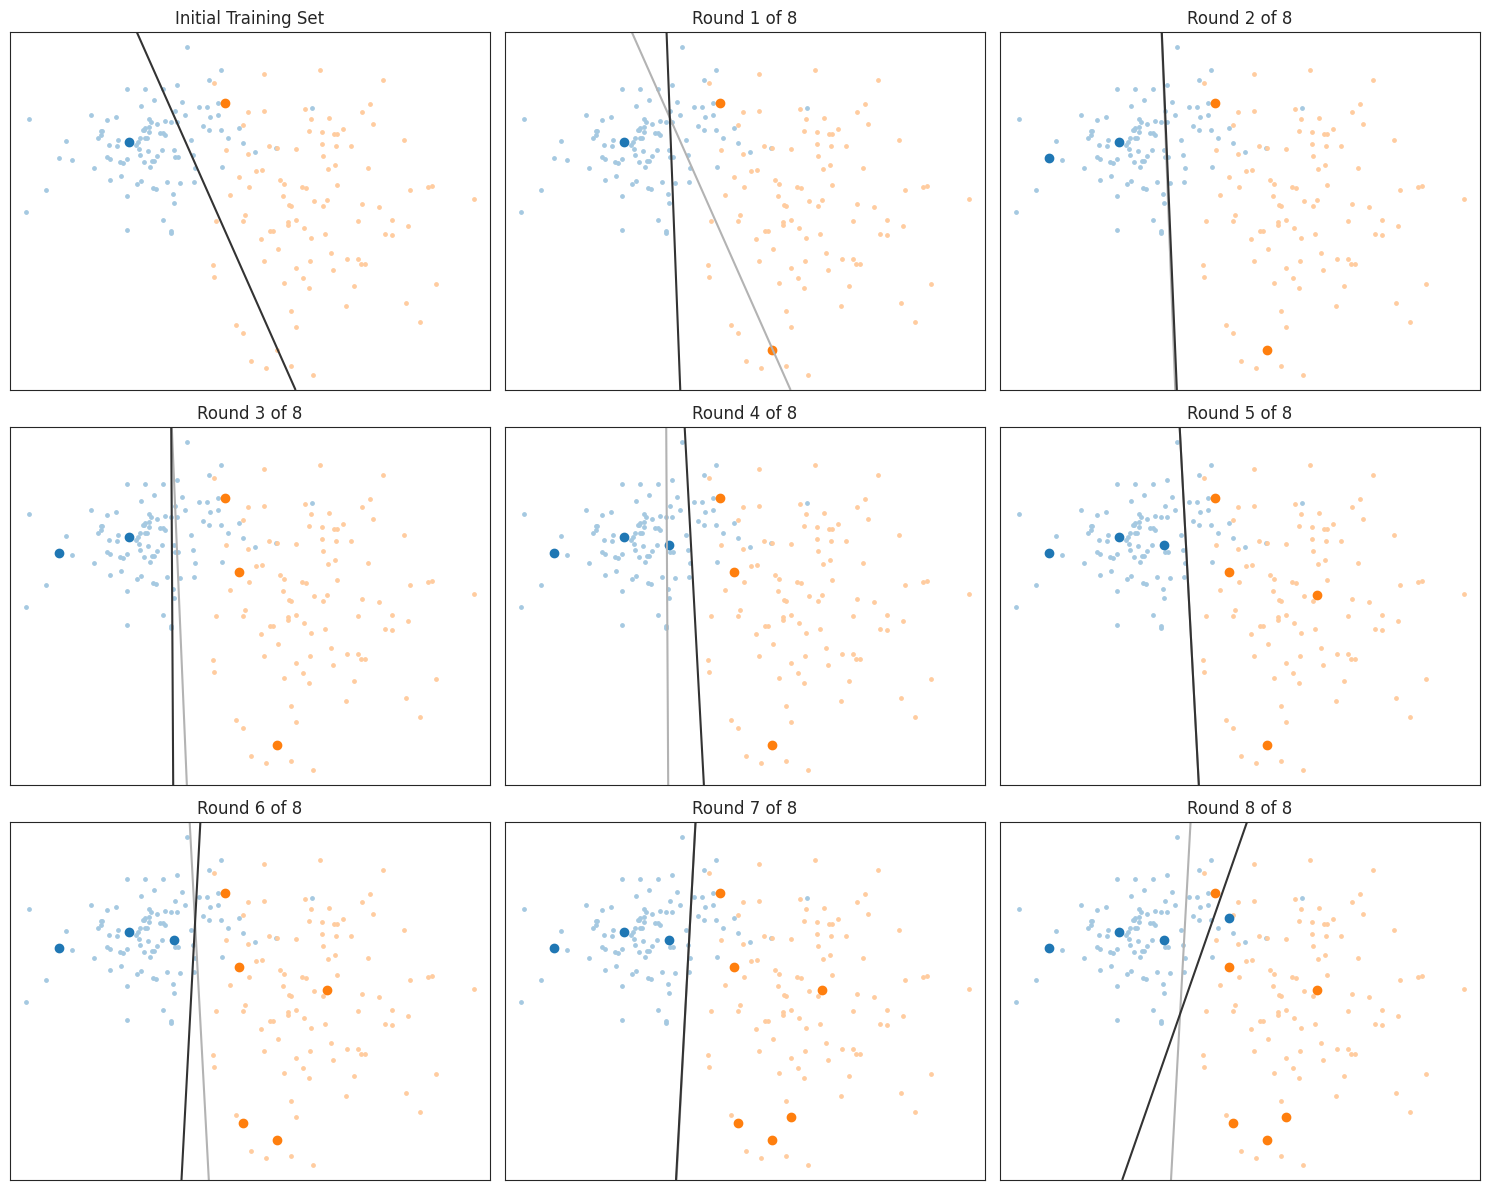

In [4]:
# 初始化随机种子
np.random.seed(42)  # 选择一个特定的随机种子

# 从每一类中随机选择一个样本作为初始训练集
starting_samples = [choice(range(N_1)), N_1 + choice(range(N_2))]
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# 绘制初始训练集和分类器
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title('Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# 进行8轮随机采样
for round_num in range(8):  
    new_sample = choice([i for i in range(N_1 + N_2) if i not in train_idx])
    train_idx.append(new_sample)
    previous_clf = clf
    clf = LogisticRegression().fit(X[train_idx], y[train_idx])

    ax = plt.subplot(3, 3, round_num + 2)
    plt.title(f'Round {round_num + 1} of 8')
    plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

plt.tight_layout()
plt.show()

## 不确定性采样（Uncertainty Sampling）
 

最简单的思路是：模型越不确定的样本，越值得标注。这种方法叫做不确定性采样，适用于任何能够评估自己预测不确定性的模型。比如，有些模型可以给出每个类别的概率 $\hat{P}(y \mid x)$ ，我们可以用最可能的类别的概率来衡量不确定性，公式是：

$$
u(x)=1-\max _y \hat{P}(y \mid x)
$$


这个标准叫做最小置信度分数，意思是选择那些模型最＂没把握＂的样本，也就是所有类别的概率都差不多的情况。

**最小间隔分数（Minimum Margin Score）**

除了最小置信度分数，还有一种情况也值得关注：当模型只能排除一部分类别，但剩下的两个类别概率几乎相等时。这时候可以用最小间隔分数：

$$
u(x)=\hat{P}\left(y_2^* \mid x\right)-\hat{P}\left(y_1^* \mid x\right)
$$


其中 $y_1^*$ 和 $y_2^*$ 分别是模型认为最可能和第二可能的类别。这个标准会选择那些模型在两个类别之间＂犹豫不决＂的样本，通常这些样本位于两个类别的分界线附近。

**熵分数（Entropy Score）**

第三个标准来自信息论，叫做嫡分数。熵可以理解为＂混乱程度＂，在这里表示模型对样本类别的不确定性。公式是：

$$
u(x)=\mathbb{E}[-\log \hat{P}(y \mid x)]
$$


简单来说，熵分数衡量的是模型在知道样本标签后会获得多少信息。如果模型对某个样本的类别非常确定，熵分数会很低；如果模型对类别＂拿不准＂，熵分数会很高。这个标准和最小间隔分数有点像，但它会同时考虑所有类别，而不仅仅是前两个最可能的类别。

通俗来说，不确定性采样的核心思想是：**让模型自己决定哪些样本最值得标注**。 通过选择模型最不确定的样本，我们可以用更少的标注数据训练出更好的模型。

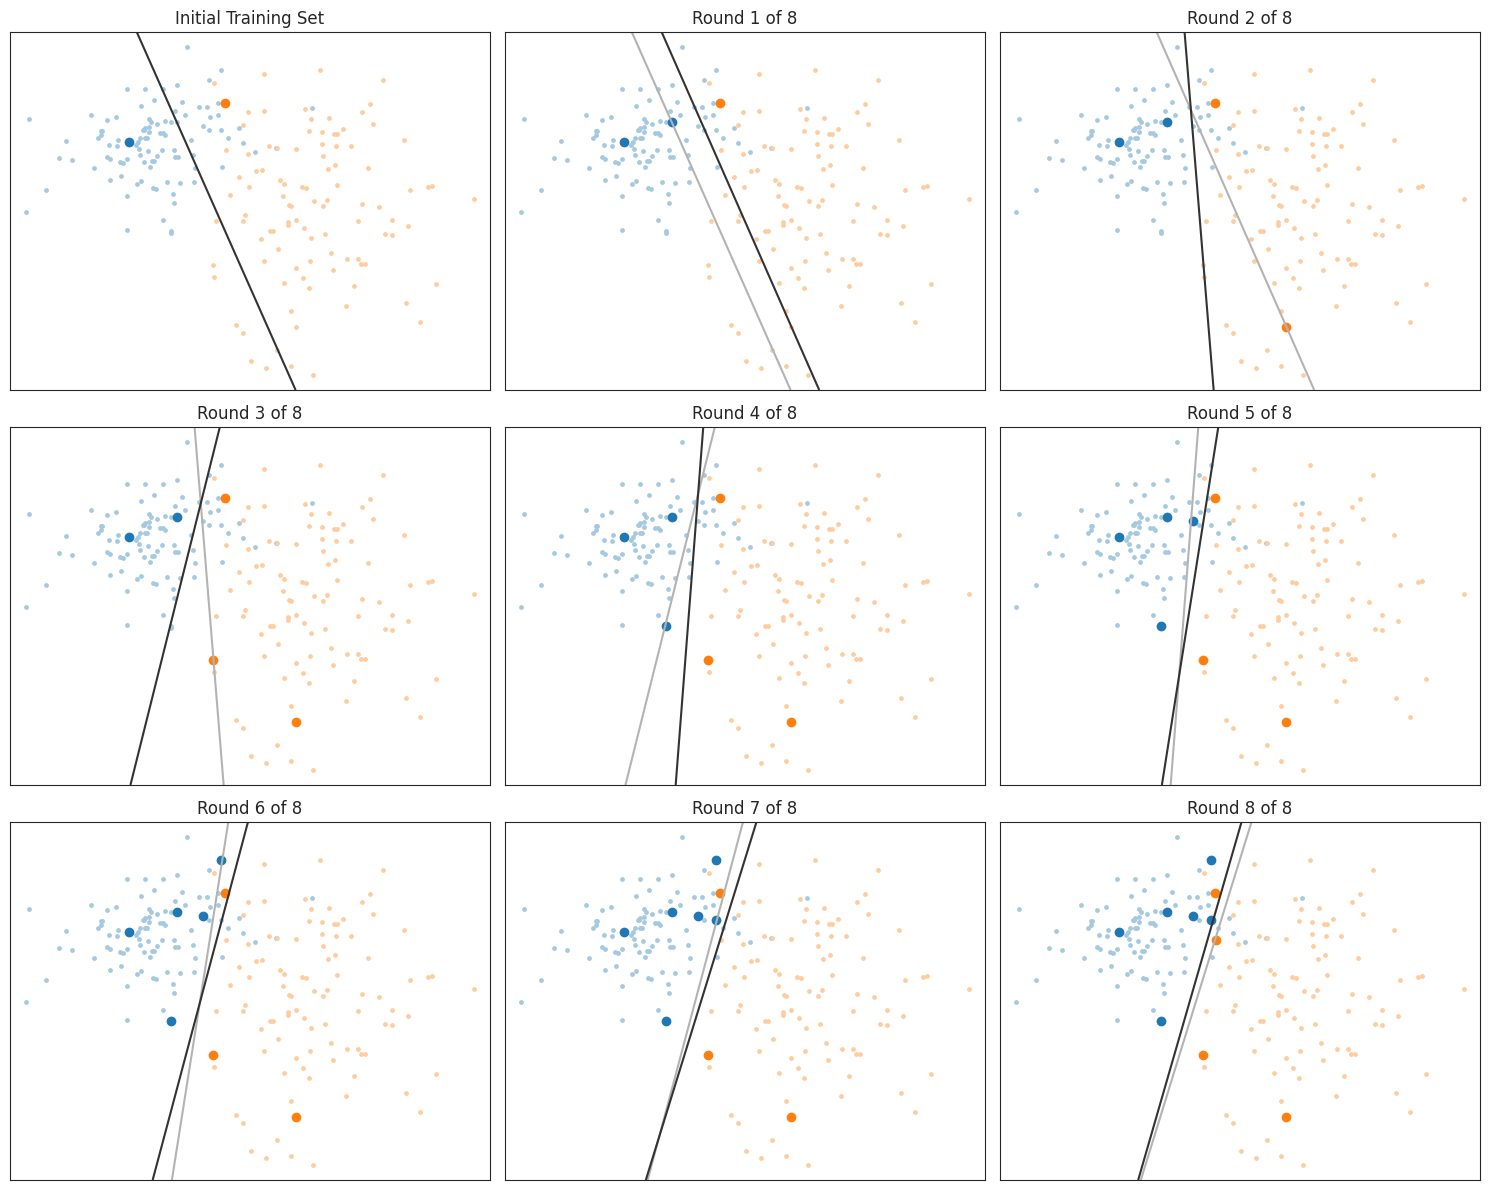

In [5]:
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from typing import Callable, Sequence

# 定义不确定性采样准则
def least_confidence(posterior: np.ndarray) -> np.ndarray:
    """Least confidence criterion, u(x) = 1 - max P(y | x)."""
    return 1 - posterior.max(axis=1)

def minimum_margin(posterior: np.ndarray) -> np.ndarray:
    """Minimum margin criterion, u(x) = P(y_2* | x) - P(y_1* | x), where y_1* and y_2* are the two most probable classes."""
    most_probable = posterior.max(axis=1)
    mask_most_probable = (posterior == most_probable.reshape(-1, 1))
    second_most_probable = (posterior - mask_most_probable).max(axis=1)
    return second_most_probable - most_probable

def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
    """Entropy criterion, u(x) = -E[log P(y | x)]."""
    return entropy(posterior, axis=1)

def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
    """Get the index of an unknown sample where the classifier is most uncertain about the label."""
    unknown_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
    posterior = clf.predict_proba(X[unknown_indices])
    utility = criterion(posterior)
    return unknown_indices[np.argmax(utility)]

# 初始化训练集和分类器
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# 绘制初始训练集和分类器
plt.figure(figsize=(15, 12))
plt.subplot(3, 3, 1)
plt.title('Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# 进行8轮不确定性采样
for round_num in range(8):  # 避免与内置函数 round 冲突
    new_sample = uncertainty_sampling(clf, X, train_idx, criterion=entropy_criterion)
    train_idx.append(new_sample)

    plt.subplot(3, 3, round_num + 2)
    plt.title(f'Round {round_num + 1} of 8')
    previous_clf = clf
    clf = LogisticRegression().fit(X[train_idx], y[train_idx])
    plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

plt.tight_layout()
plt.show()

## 委员会查询

委员会查询（QBC）的灵感来自于集成学习方法。它不是只用一个分类器，而是考虑一个由多个分类器 $C=h_1, \ldots, h_C$ 组成的＂委员会＂的决策。每个分类器的目标类别相同，但它们的底层模型或对数据的视角不同。随机森林就是一个典型的例子：每个分类器都是决策树，但每棵树是基于不同的特征子集训练的。

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline">  如何判断未标记样本的价值？

很简单：如果委员会成员对某个样本的类别意见一致，那就不需要再标注这个样本了；如果委员会成员意见不一致，那就需要向预言机 oracle（比如人类标注员）询问这个样本的标签。换句话说，委员会对某个样本的分歧程度可以代表这个样本的价值。



#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 如何衡量分歧？

如果委员会有很多成员，我们可以通过每个类别 $y$ 的得票数 $V(y)$ 来估计类别的概率，公式是：

$$
\hat{P}(y \mid x) \approx \frac{V(y)}{C}
$$


不过，委员会中的分类器数量 $C$ 通常不够多，无法得到可靠的概率估计。这时候，我们可以用之前提到的熵来衡量分歧，这种方法叫做投票熵（Vote Entropy）：

$$
u(x)=-\sum_y \frac{V(y)}{C} \log \frac{V(y)}{C}
$$


其中 $V(y)=\left|\left\{h_i \mid h_i(x)=y\right\}\right|$ 表示投票给类别 $y$ 的分类器数量。

In [6]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import entropy
from matplotlib.pyplot import figure, subplot, title, contour, show
from numpy import array, argmax, meshgrid, apply_along_axis, bincount, ravel, c_

In [7]:
# 返回集成分类器对输入数据 X 中每个样本的投票结果
def get_ensemble_votes(ensemble, X: np.ndarray, n_classes) -> np.ndarray: 
    predictions = ensemble._predict(X)
    return np.apply_along_axis(np.bincount, axis=1, arr=predictions, minlength=n_classes) #对每个样本的预测结果进行投票计数，确保每个类别的投票数都被统计。

# 计算未标记样本的投票熵，并返回熵最大的样本索引。
def vote_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int], n_classes: int) -> int:
    unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
    votes = get_ensemble_votes(ensemble, X[unknown_indices], n_classes=n_classes)
    utility = entropy(votes / len(ensemble.estimators), axis=1)
    return unknown_indices[argmax(utility)]

def plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx):
    xx, yy = meshgrid_from_bounds(X.min(0) - 1, X.max(0) + 1)

    try:
        proba = ensemble.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        votes = get_ensemble_votes(ensemble, np.c_[xx.ravel(), yy.ravel()], n_classes=len(np.unique(y)))
        proba = (votes / len(ensemble.estimators))

    contour(xx, yy, proba[:, 0].reshape(xx.shape), levels=[0.5])
    plot_data(X, y, train_idx)

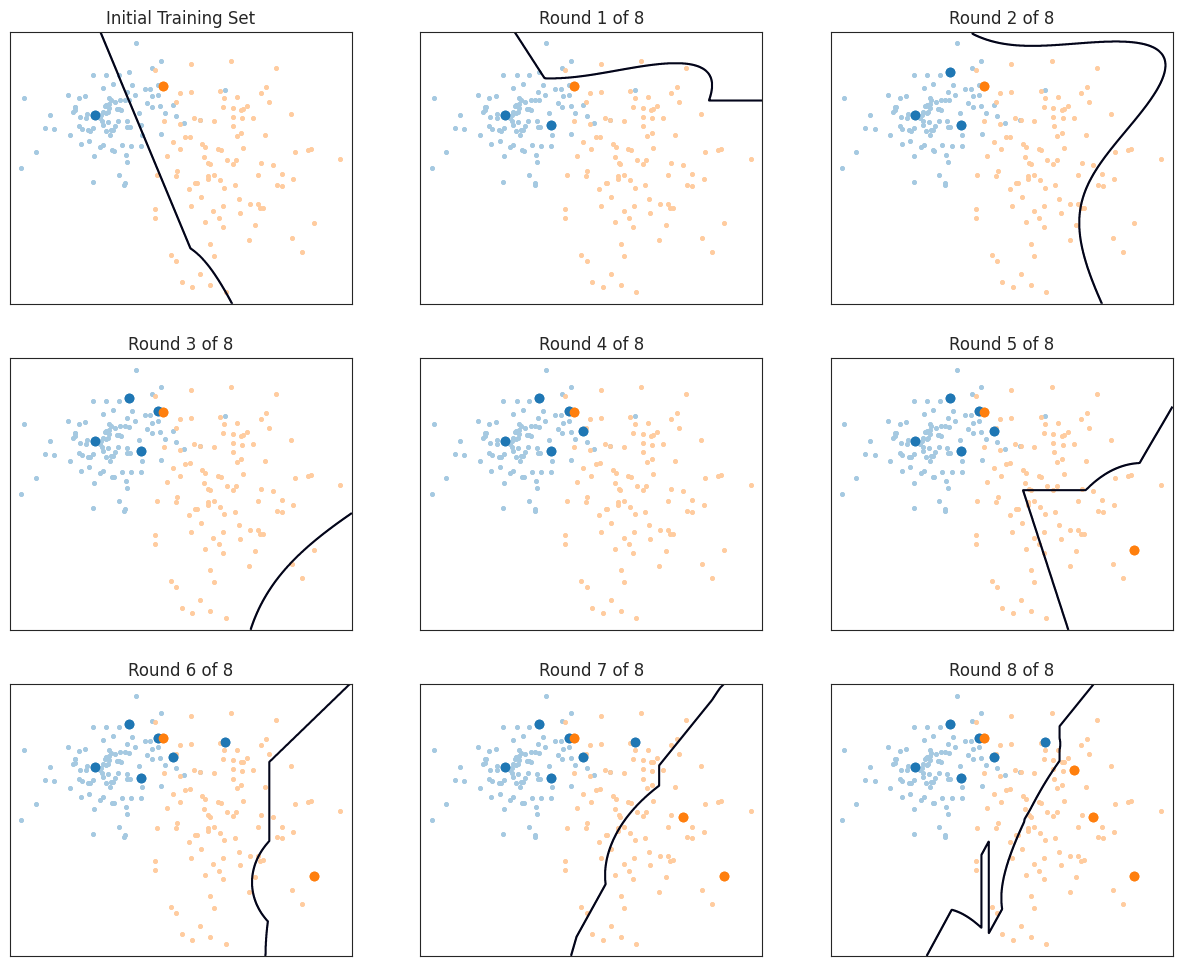

In [8]:
train_idx = starting_samples[:]
#  硬投票
ensemble = VotingClassifier([
    ('linear svm', LinearSVC(dual=False)),
    ('rbf svm', SVC()),
    ('poly svm', SVC(kernel='poly')),
    ('decision tree', DecisionTreeClassifier()),
    ('passive agressive', PassiveAggressiveClassifier()),
    ('naive bayes', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='hard').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
    new_sample = vote_entropy(ensemble, X, train_idx, n_classes=2)
    train_idx.append(new_sample)

    subplot(3, 3, round+2)
    title(f'Round {round + 1} of 8')
    ensemble = ensemble.fit(X[train_idx], y[train_idx])
    plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
    plot_data(X, y, train_idx)

show()

### 共识熵

最大化 $u(\mathbf x) = -\sum_y\overline P(y|\mathbf x)\log \overline P(y|\mathbf x)$ 的样本查询标签。

$\overline P(y|\mathbf x) = \frac{1}{C} \sum_{h_i \in \mathcal C} \hat P_i(y|\mathbf x)$ 是类 $y$ 的共识概率，而 $\hat P_i(y|\mathbf x)$ 是集合 $\mathcal C$ 中分类器 $h_i$ 的后验类概率估计。

In [9]:

def consensus_entropy(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  probas = ensemble.predict_proba(X[unknown_indices])
  utility = entropy(probas, axis=1)
  return unknown_indices[argmax(utility)]

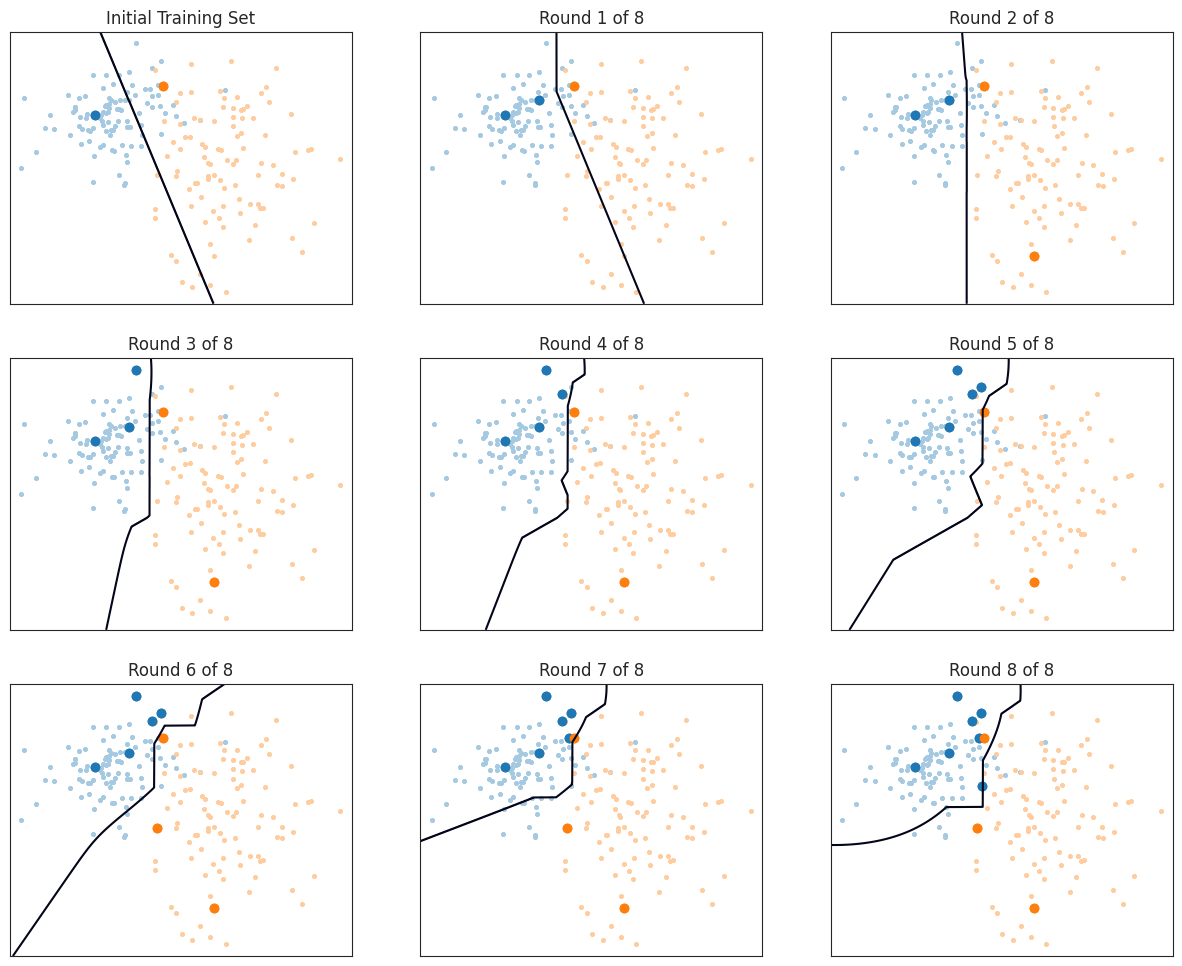

In [10]:
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
  new_sample = consensus_entropy(ensemble, X, train_idx)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

### 最大分歧

查询样本标签，使 $u(\mathbf x) = \sum_{h_i \in \mathcal C} D_{\text{KL}}(\hat P_i \| \overline P)$ 最大化，即委员会成员与共识之间的平均 Kullback Leibler 分歧最大。

In [11]:
def max_disagreement(ensemble: VotingClassifier, X: np.ndarray, train_idx: Sequence[int]) -> int:
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  
  probas = ensemble._collect_probas(X[unknown_indices])
  consensus = np.mean(probas, axis=0)
  utility = array([
       np.apply_along_axis(entropy, axis=1, arr=probas[:, i], qk=qk).sum()
       for i, qk in enumerate(consensus)
  ])

  return unknown_indices[argmax(utility)]

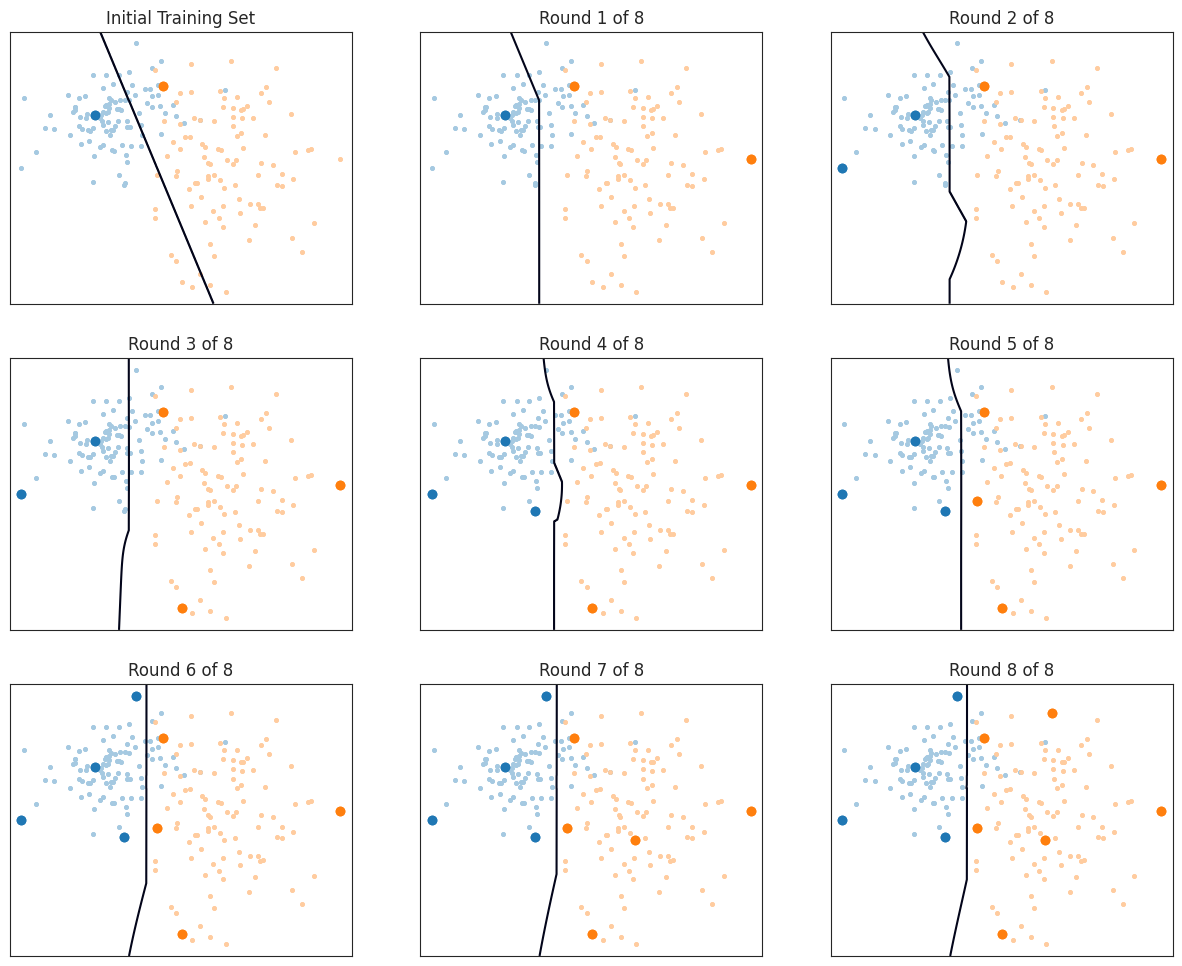

In [12]:
train_idx = starting_samples[:]
ensemble = VotingClassifier([
  ('logistic regression', LogisticRegression()),
  ('decision tree', DecisionTreeClassifier()),
  ('naive bayes', GaussianNB()),
  ('knn', KNeighborsClassifier(n_neighbors=2))
], voting='soft').fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
plot_data(X, y, train_idx)

for round in range(8):
  new_sample = max_disagreement(ensemble, X, train_idx)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  ensemble = ensemble.fit(X[train_idx], y[train_idx])
  plot_ensemble_voting_decision_boundary(ensemble, X, y, train_idx)
  plot_data(X, y, train_idx)

---

## 预期模型变化（Expected Model Change）

* 不确定性采样（Uncertainty Sampling） 和 委员会查询（QBC在概念上很相似：你训练一个模型（或一个集成模型），然后用它对未见过样本的输出来判断这个样本的价值。然而，这种方法可能会选择那些靠近决策边界的样本，**而这些样本并不一定对学习数据的整体结构有帮助。**

* 预期模型变化（EMC）试图解决这个问题，它的核心思想是：关注未来。我们不再问模型对某个样本的预测有多不确定，而是问：如果我们知道这个样本的标签，模型会发生多大的变化。那些能让模型发生最大变化的样本，就是最有价值的样本。

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 如何实现预期模型变化？ 

最直接的方法是：为每个可能的标签训练一个模型，然后比较新旧模型之间的差异。不过，这种方法计算量非常大，通常不现实。幸运的是，有一些方法可以让这个思路变得更可行。

对于基于梯度的优化方法（比如深度学习），我们可以用**训练梯度的预期长度**来近似模型的变化。公式是：

$$
u(x)=\mathbb{E}_y[\|\nabla \ell(h ; \ell \cup(x, y))\|] \approx \mathbb{E}_y[\|\nabla \ell(h ;(x, y))\|],
$$


其中 $\ell(h ; \ell)$ 是损失函数，$\ell$ 是训练集。这个近似基于两个假设：

1．$h$ 是一个已经训练好的模型。

2．训练数据是独立同分布的。

这意味着梯度的变化只来自于样本 $x$ ，所以我们只需要为每个 $x$ 计算损失函数，而不需要为整个训练集计算。

通俗来说，预期模型变化（EMC） 的核心思想是：**选择那些能让模型发生最大变化的样本**。与不确定性采样和委员会查询不同，EMC 关注的是样本对模型未来的影响，而不是模型当前的预测不确定性。

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设 model 是一个已经训练好的模型
# X_unlabeled 是未标记的数据集

def compute_gradients(model, X_unlabeled):
    gradients = []
    for x in X_unlabeled:
        x = torch.tensor(x, requires_grad=True)
        output = model(x)
        loss = nn.CrossEntropyLoss()(output, model.predict(x))  # 使用伪标签
        loss.backward()
        gradients.append(x.grad.norm())  # 计算梯度的范数
    return gradients

def select_samples(model, X_unlabeled, top_k=10):
    gradients = compute_gradients(model, X_unlabeled)
    top_k_indices = torch.topk(torch.tensor(gradients), top_k).indices
    return top_k_indices

---

## 预期误差减少（Expected Error Reduction, EER） 

旨在通过选择那些能够最大程度减少模型在未见过数据上的预测误差的样本进行标注，从而提升模型的性能。EER 的核心思想是：**选择那些标注后能够显著减少模型在未来数据上的预测误差的样本。**

EER 的核心问题是：**哪些样本的标注能够最大程度地减少模型的预测误差？**

思路：

* 对于每个末标记样本 $x$ ，假设我们知道它的真实标签 $y$ （伪标签），然后用这个新标注的样本 $(x, y)$ 来更新模型。
* 更新后的模型会在其他未标记样本 $x^{\prime}$ 上做出更好的预测，从而减少预测误差。
* EER 的目标是选择那些能够最大程度减少预测误差的样本进行标注。

---

## 密度加权（Density Weighting）

密度加权的核心思想是：在选择样本进行标注时，不仅要考虑模型的不确定性，还要考虑样本在数据分布中的代表性。通过将样本的效用与密度估计结合起来，密度加权能够避免选择那些位于稀疏区域或异常值的样本。

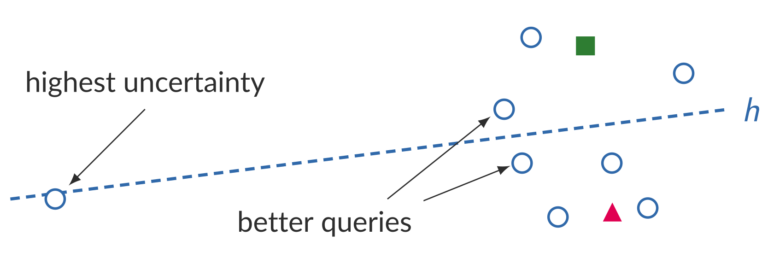

密度加权通过将样本的效用 $u(x)$ 与样本在特征空间中的密度估计 $\hat{p}(x)$ 结合起来，解决上述问题。具体来说，密度加权的效用函数定义为：

$$
u^{\prime}(x)=u(x) \hat{p}(x)^\beta
$$


其中：

－$u^{\prime}(x)$ 是调整后的样本效用。

－$\hat{p}(x)$ 是样本 $x$ 的密度估计。

－$\beta$ 是一个超参数，用于控制密度加权的强度。 

**密度加权的主要作用是**：避免选择特征空间中稀疏区域的样本进行标注。通过引入密度估计，密度加权能够确保选择的样本不仅具有高不确定性，而且在数据分布中具有代表性。这样可以避免选择异常值或离群点，从而提高标注数据的质量。

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline">  我有一个问题，主动学习的目的不是使得训练更高效吗？可算在寻找价值样本的时候看上去会有大量的计算成本，例如EER,EMC等，这不是背道而驰吗？还是说主动学习除了高效计算，还有其他目标，例如计算更准？

